In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.metrics import mean_squared_error
# from sklearn.cross_validation import KFold
import pandas as pd
import math as m
from sklearn.datasets import load_diabetes
import time
import seaborn as sns; sns.set()
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

/Users/aleksejfilippov/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
X, y = load_diabetes(True)
X = pd.DataFrame(X)
y = pd.DataFrame(y)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True)
X_train = torch.tensor(X_train.values.tolist())
X_test = torch.tensor(X_test.values.tolist())
y_train = torch.tensor(y_train.values.tolist())
y_test = torch.tensor(y_test.values.tolist())

# PyTorch neural net.
## Class Net. 4 layers. Batch-norm and dropout.
###  Net parameters:
#### p - probability of one element in FC layer to be zeroed bu dropout.
#### weights - list of 4 elements, k element of witch referes to othe number of neurons in k layer of net.

In [5]:
class Net(nn.Module):
    def __init__(self, p: float, weights: list):
        super(Net, self).__init__()
        self.p = p
        self.__flag = True
        self.__weights = weights

        self.layer0 = nn.Linear(self.__weights[0], self.__weights[1])
        self.bn0 = nn.BatchNorm1d(self.__weights[1])

        self.layer3 = torch.nn.Linear(self.__weights[1], self.__weights[2])
        self.bn3 = nn.BatchNorm1d(self.__weights[2])

        self.layer7 = torch.nn.Linear(self.__weights[2], self.__weights[3])

    def forward(self, x):
        x = F.relu(self.bn0(self.layer0(x)))

        x = F.relu(self.bn3(self.layer3(F.dropout(x, self.p))))

        x = self.layer7(F.dropout(x, self.p))
        return x


    def set_drop_out(self, p: float):  # Enables to change dropaout while training
        self.p = p

    def use_drop_out(self, flag: bool = True):  # Turn on/off dropout
        self.__flag = flag
        if self.__flag == True:
            pass
        else:
            self.p = 0


## Class Net_coach. 
#### In train method an object of Net class is created and then in a loop, the net is learning with parameters given in cinstructor. get_trainig_plot method drowes a plot of RMSE( epoch )

In [6]:
class Net_coach():
    def __init__(self, this_X_train, this_X_test,
                 this_y_train, this_y_test):
        self._is_trained = False  # Need this flag to know whether it is possible to plot the results
        self.X_train = this_X_train
        self.X_test = this_X_test
        self.y_train = this_y_train
        self.y_test = this_y_test

    def __init_weights(self, model):  # Very often exploding gradient appears, witch leads to inf solutions.
        if type(model) == nn.Linear:  # Despite batch-normalization weights initialization is requiered
            torch.nn.init.xavier_normal_(model.weight)
            model.bias.data.fill_(0.01)

    def train(self, w0, w1, w2, w3, p, lr):
        self._is_trained = True

        self.__net = Net(p=p, weights=[w0, w1, w2, w3])
        self.__net.apply(self.__init_weights)

        self.__criterion = torch.nn.MSELoss()
        self.__optimizer = torch.optim.Adam(self.__net.parameters(), lr=lr)

        self.epo = []
        self.los_train = []
        self.los_test = []
        self.losss_test = []

        N_EPOCHS = 100
        N_LAST_VALS = 20  # Number of last values of RMSE that you look at when calculating mean RMSE
        for epoch in range(N_EPOCHS):
            y_pred = self.__net(self.X_train)
            y_pred_test = self.__net(self.X_test)

            loss_train = self.__criterion(y_pred, self.y_train)
            lossse_test = mean_squared_error(y_pred_test.tolist(), self.y_test.tolist())
            loss_test = self.__criterion(y_pred_test, self.y_test)

            self.__optimizer.zero_grad()
            loss_train.backward()
            self.__optimizer.step()

            self.epo.append(epoch)
            self.los_train.append(loss_train.item())
            self.los_test.append(loss_test.item())
            self.losss_test.append(lossse_test)
        return self.epo, self.los_train, self.losss_test, np.sqrt(np.mean(self.losss_test[-N_LAST_VALS:]))
    def get_training_plot():
        if self._is_trained == False:
            raise Exception('Call .train method first.')
        else:
            _, ax = plt.subplots()
            ax.plot(self.epo, self.los_train, label='train')
            ax.plot(self.epo, self.losss_test, label='test')
            legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')


## Class Grid. It provides a convenient way of grid search for parmeters of net.
#### In private method __get_error_on_cv for each element of initial dataset a new Net_coach object is created.
#### Then depending on a parameter provided, method grid_1d returns a list of RMSE for each dataset split.
#### grid_2d method returns a grid w1 x w2 of RMSE for each dataset split.
#### Basicly last method visualizes a 2d function RMSE(w1, w2) using seaborn.heatmap.

In [18]:
class Grid():
    '''
    Notice that you can both search for w1 and w2 independently using grid_1d and search it mutually using grid_2d.

    __init__ 

    parameters:
        n_folds: int - number of parts for incomming data to be splitted into.
        n_ieter: int - number of iterations for splitting
        this_X: array-like - dataset
        this_y: array-like = labels

    '''

    def __init__(self, n_folds, n_iter, this_X, this_y):

        self.n_folds = n_folds
        self.n_iter = n_iter
        self.this_X = this_X
        self.this_y = this_y

        # Setting default parameters
        self.w0 = self.this_X.shape[1]  # Constant for a particular net
        self.w1 = 4
        self.w2 = 14
        self.w3 = self.this_y.shape[1]  # Constant for a particular net
        self.p = 0.75
        self.lr = 0.75

    '''
    __get_error_on_cv
    
        Splits this_X and this_y into train and test parts randomly  in order to build a viable cross-validation. Then
        for each split it creates a Net_coach, calls method train and gets results, witch are to be averaged further.
    
    parameters:
        w0, w1, w2, w3: int - weights
        p: float - probability for dropout
        lr: float - learning rate for Adam optimizer

    '''

    def __get_error_on_cv(self, w0, w1, w2, w3, p, lr):
        kf = KFold(self.n_folds)

        train_ind = []
        test_ind = []
        for train_index, test_index in kf.split(X):
            train_ind.append(train_index)
            test_ind.append(test_index)

        X_train_tensors = [torch.tensor(self.this_X.iloc[tr].values).type(torch.FloatTensor) for tr in train_ind]
        X_test_tensors = [torch.tensor(self.this_X.iloc[te].values).type(torch.FloatTensor) for te in test_ind]
        y_train_tensors = [torch.tensor(self.this_y.iloc[tr].values).type(torch.FloatTensor) for tr in train_ind]
        y_test_tensors = [torch.tensor(self.this_y.iloc[te].values).type(torch.FloatTensor) for te in test_ind]

        cv = []
        for i in range(self.n_folds):
            cv.append((X_train_tensors[i], y_train_tensors[i], X_test_tensors[i], y_test_tensors[i]))

        arrs = []
        for this_X_train, this_y_train, this_X_test, this_y_test in cv:
            trainer = Net_coach(this_X_train, this_X_test, this_y_train, this_y_test)
            ep, los_tr, los_te, arr = trainer.train(w0, w1, w2, w3, p, lr)
            arrs.append(arr)

        return np.mean(arrs)

    '''
    grid_1d
        
        Searches for best parameter on a grid given with [lower_bound, upper_bound] 
        and step (upper_bound - lower_bound) / n_values
    
    parameters: 
        parameter: str - a parameter to be inspected
        lower_bound: float
        upper_bound: float
        n_values: int
    '''

    def grid_1d(self, parameter, lower_bound, upper_bound, n_values):
        scores_arr = []
        curr_time = time.time()
        for j in range(self.n_iter):
            scores = []
            if parameter == 'w1':
                self.w1s = np.linspace(lower_bound, upper_bound, n_values).astype(int).tolist()
                for param in self.w1s:
                    scores.append(round(self.__get_error_on_cv(self.w0, param, self.w2, self.w3, self.p, self.lr), 2))

            elif parameter == 'w2':
                self.w2s = np.linspace(lower_bound, upper_bound, n_values).astype(int).tolist()
                for param in self.w2s:
                    scores.append(round(self.__get_error_on_cv(self.w0, self.w1, param, self.w3, self.p, self.lr), 2))

            elif parameter == 'p':
                self.ps = np.linspace(lower_bound, upper_bound, n_values)
                for param in self.ps:
                    scores.append(round(self.__get_error_on_cv(self.w0, self.w1, self.w2, self.w3, param, self.lr), 2))

            elif parameter == 'lr':
                self.lrs = np.linspace(lower_bound, upper_bound, n_values)
                for param in self.lrs:
                    scores.append(round(self.__get_error_on_cv(self.w0, self.w1, self.w2, self.w3, self.p, param), 2))

            scores_arr.append([scores, [np.min(scores), scores.index(np.min(scores))]])
            print('Iter: ', j, ' is complete.', 'Time: ', round(time.time() - curr_time), ' s. Progress ',
                  round(j / self.n_iter * 100), ' %')

        plt.plot(np.linspace(lower_bound, upper_bound, n_values), np.mean([x[0] for x in scores_arr], axis=0))

        return scores_arr


    def grid_2d(self, lower_bound1, upper_bound1, n_values1, lower_bound2, upper_bound2, n_values2):
        scores = []
        curr_time = time.time()
        for j in range(self.n_iter):
            outer_sc_arr = []

            for w1 in np.linspace(lower_bound1, upper_bound1, n_values1).astype(int).tolist():
                inner_sc_arr = []
                for w2 in np.linspace(lower_bound2, upper_bound2, n_values2).astype(int).tolist():
                    inner_sc_arr.append(round(self.__get_error_on_cv(self.w0, w1, w2, self.w3, self.p, self.lr), 2))
                outer_sc_arr.append(inner_sc_arr)

            scores.append(outer_sc_arr)
            print('Iter:', j, ' is complete.', 'Time:', round(time.time() - curr_time), 's. Progress ',
                  round(j / self.n_iter * 100), ' %')
        heatt = sns.heatmap(np.mean(scores, axis=0))

        return (scores)


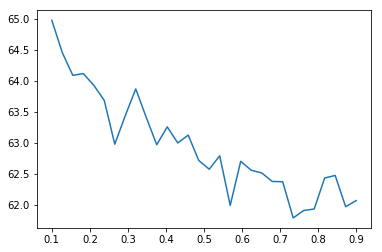

In [71]:
# %time res_lr =  Grid(40, 40, X, y).grid_1d('lr', 0.1, 0.9, 30 )
plt.plot(np.linspace(0.1, 0.9, 30), np.mean([x[0] for x in res_lr], axis = 0))
# plt.savefig('rmse_lr.png')

### Upper plot shows RMSE as a function of lr. Optimal parameter is lr = 0.75

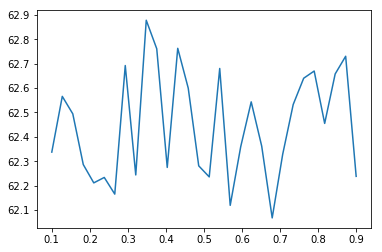

In [72]:
%time res_p =  Grid(40, 40, X, y).grid_1d('p', 0.1, 0.9, 30 )
plt.plot(np.linspace(0.1, 0.9, 30), np.mean([x[0] for x in res_p], axis = 0))
# plt.savefig('rmse_p.png')

### Upper plot shows RMSE as a function of p. It can be concluted from the plot that model quality does not realy depend on parameter p. So let's just set it p = 0.7

In [377]:
ws_gr = Grid(10, 10, X, y).grid_2d(1, 10, 10, 1, 30, 30)

Iter:  0  is complete
Iter:  1  is complete
Iter:  2  is complete
Iter:  3  is complete
Iter:  4  is complete
Iter:  5  is complete
Iter:  6  is complete
Iter:  7  is complete
Iter:  8  is complete
Iter:  9  is complete


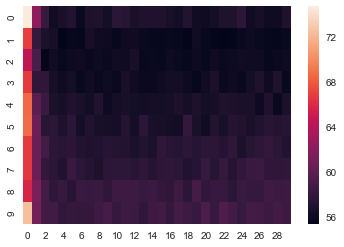

In [380]:
heat = sns.heatmap(np.mean(ws_gr, axis = 0))

Iter: 0  is complete. Time: 4073 s. Progress  0  %
Iter: 1  is complete. Time: 8141 s. Progress  10  %
Iter: 2  is complete. Time: 12212 s. Progress  20  %
Iter: 3  is complete. Time: 16291 s. Progress  30  %
Iter: 4  is complete. Time: 20361 s. Progress  40  %
Iter: 5  is complete. Time: 24435 s. Progress  50  %
Iter: 6  is complete. Time: 47300 s. Progress  60  %
Iter: 7  is complete. Time: 55531 s. Progress  70  %
Iter: 8  is complete. Time: 59677 s. Progress  80  %
Iter: 9  is complete. Time: 63887 s. Progress  90  %
CPU times: user 11h 26min 25s, sys: 20min 50s, total: 11h 47min 15s
Wall time: 17h 44min 47s


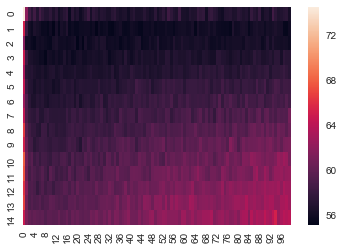

In [497]:
# %time ws_gr1 = Grid(10, 10, X, y).grid_2d(1, 15, 15, 1, 100, 100)

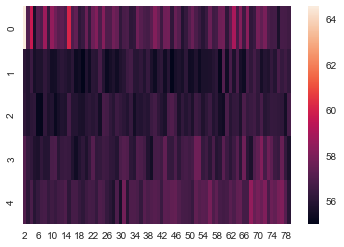

In [419]:
heat = sns.heatmap(pd.DataFrame(np.mean(ws_gr1, axis = 0)).iloc[:, 2:])

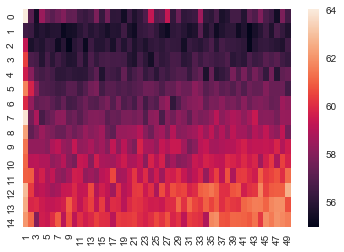

In [391]:
# ws_gr1 = Grid(10, 5, X, y).grid_2d(1, 5, 5, 1, 80, 80)
# heat = sns.heatmap(pd.DataFrame(np.mean(ws_gr1, axis = 0)).iloc[:, 1:])

### Upper images sow us RMSE as a function of w1(vertically) and w2(horizontally). At the top of a picture you can define an region of dark collors (witch is related to lower RMSE). So judging by this picture you can choose (w1, w2) parametrs from the center of an upper region. For example (w1, w2) = (3, 8).

## Now let's build  model with optimal parameters

52.37000637453292


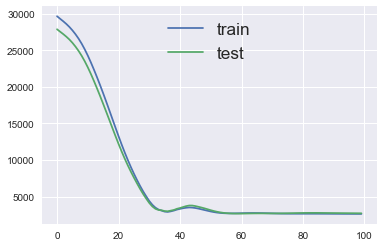

In [489]:
trainer = Net_coach(X_train, X_test, y_train, y_test)
ep, los_tr, los_te, arr= trainer.train(10, 2, 50, 1, 0.7, 0.05)
arr

_, ax = plt.subplots()
ax.plot(ep, los_tr, label = 'train')
ax.plot(ep, los_te, label = 'test')
legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

print(np.sqrt(np.mean(los_te[-20:])))